In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%matplotlib inline

import wandb
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from glob import glob
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns


from opf.utils import model_from_parameters
from opf.plot import plot_equality, plot_inequality

%aimport opf
%aimport opf.modules
%aimport opf.constraints
%aimport opf.utils
%aimport opf.power
%aimport opf.plot

mpl.rcParams['text.usetex'] = False

In [3]:
api = wandb.Api()
run = api.run("damowerko/opf/27657zvr")
data_dir = "../data/"
log_dir = "../logs/"

barrier, trainer, dm = model_from_parameters(
    run.config,
    gpus=0,
    logger=None,
    data_dir=data_dir,
    patience=100
)
checkpoint_directory = f"{log_dir}opf/{run.id}/checkpoints/"
print("Searching in", checkpoint_directory)

files = list(glob(checkpoint_directory + "*.ckpt"))
print("Found", files)
assert len(files) == 1
checkpoint = torch.load(files[0], map_location=lambda storage, loc: storage)

barrier.load_state_dict(checkpoint["state_dict"])

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Searching in ../logs/opf/27657zvr/checkpoints/
Found ['../logs/opf/27657zvr/checkpoints/epoch=178-step=63008.ckpt']


/home/damow/.pyenv/versions/opf/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:596: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


<All keys matched successfully>

In [4]:
dm.setup("test")
barrier.double()
barrier.detailed_metrics = True

results = []
for load, acopf in tqdm(dm.test_dataloader()):
    batch = (load.double(), acopf.double())
    result = barrier.test_step(batch)
    result = {k: v.item() for k,v in result.items()}
    results.append(result)
df = pd.DataFrame(results)

100%|██████████| 798/798 [00:16<00:00, 47.92it/s]


In [5]:
(df[["test/cost","test/inequality/rate"]].mean(),
df[[
    "test/inequality/error_max",
    "test/inequality/active_power/error_max",
    "test/inequality/reactive_power/error_max",
    "test/inequality/voltage_magnitude/error_max",
    "test/inequality/forward_rate/error_max",
    "test/inequality/backward_rate/error_max",
    "test/inequality/voltage_angle_difference/error_max",
]].max())

(test/cost               1.416982
 test/inequality/rate    0.001910
 dtype: float64,
 test/inequality/error_max                             0.048021
 test/inequality/active_power/error_max                0.000000
 test/inequality/reactive_power/error_max              0.000000
 test/inequality/voltage_magnitude/error_max           0.000000
 test/inequality/forward_rate/error_max                0.048021
 test/inequality/backward_rate/error_max               0.042167
 test/inequality/voltage_angle_difference/error_max    0.000000
 dtype: float64)

# Statistics

In [6]:
print(f"""
Mean violation rate: {df["test/inequality/rate"].max()}
Rate of any violation: {(df["test/inequality/rate"] > 1e-8).sum() / len(df)}
GNN Cost: {df["test/cost"].mean()}
IPOPT Cost: {df["acopf/cost"].mean()}
""")


Mean violation rate: 0.008130080997943878
Rate of any violation: 0.5651629072681704
GNN Cost: 1.4169824542355751
IPOPT Cost: 1.413974609483106



# Histograms

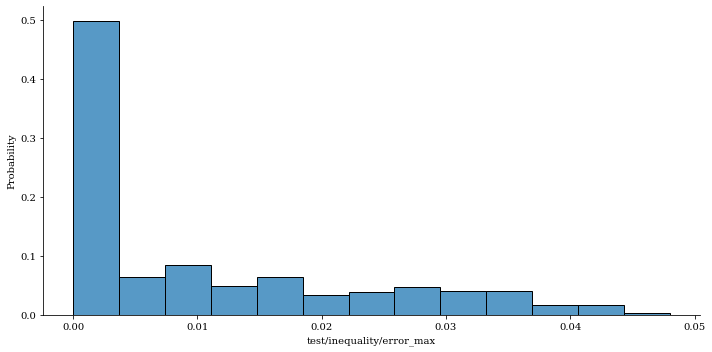

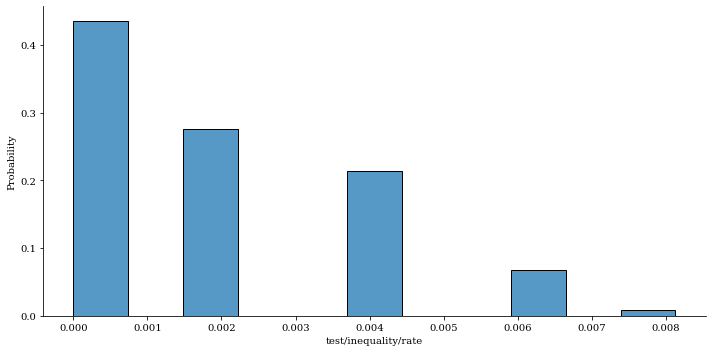

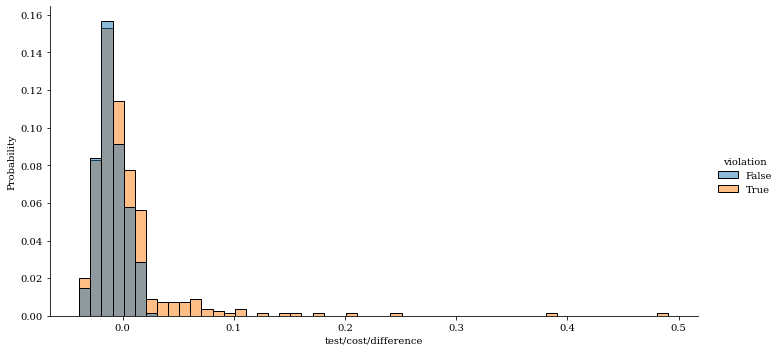

In [7]:
sns.displot(df, x="test/inequality/error_max", aspect=2, stat="probability")
sns.displot(df, x="test/inequality/rate", aspect=2, stat="probability")

# Cost improvement
df["test/cost/difference"] = df["acopf/cost"] - df["test/cost"]
df["violation"] = df["test/inequality/rate"] > 1e-8
sns.displot(df, x="test/cost/difference", binwidth=0.01, aspect=2, hue="violation", stat="probability")

# Visualizing Violations

In [8]:
sort_term = "test/inequality/error_max"
quantile = 1

s = df[sort_term]
index = (s.sort_values()[::-1] <= s.quantile(quantile)).idxmax()
print(sort_term, s[index])
print("Idx", index)
df.iloc[index][[
    "test/cost",
    "test/inequality/error_max",
    "test/inequality/active_power/error_max",
    "test/inequality/reactive_power/error_max",
    "test/inequality/voltage_magnitude/error_max",
    "test/inequality/forward_rate/error_max",
    "test/inequality/backward_rate/error_max",
    "test/inequality/voltage_angle_difference/error_max",
]]

test/inequality/error_max 0.04802063304086679
Idx 269


test/cost                                               1.41271
test/inequality/error_max                             0.0480206
test/inequality/active_power/error_max                        0
test/inequality/reactive_power/error_max                      0
test/inequality/voltage_magnitude/error_max                   0
test/inequality/forward_rate/error_max                0.0480206
test/inequality/backward_rate/error_max               0.0348785
test/inequality/voltage_angle_difference/error_max            0
Name: 269, dtype: object

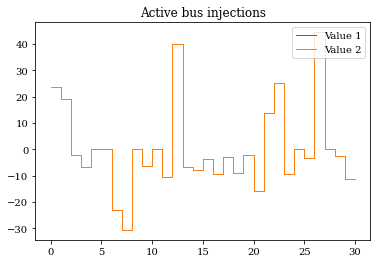

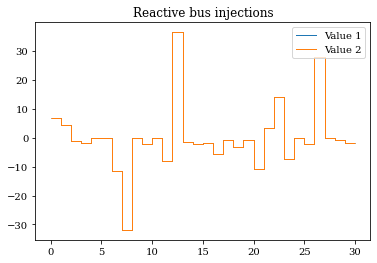

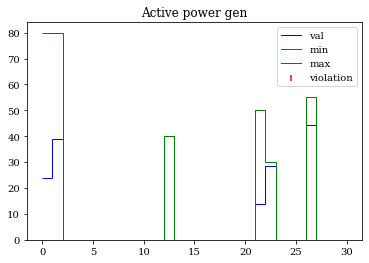

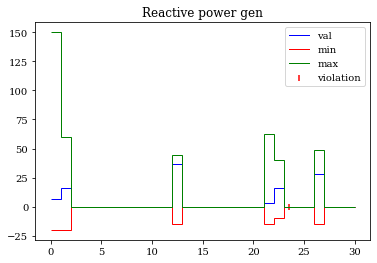

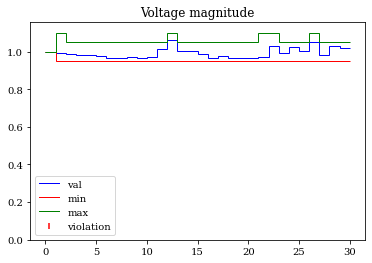

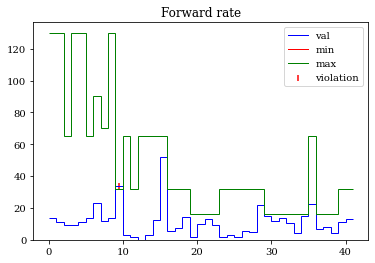

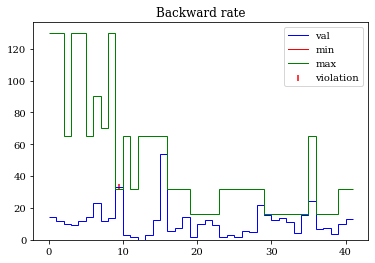

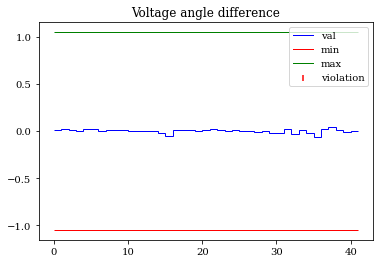

In [9]:
dataset = list(dm.test_dataloader())
barrier.double()
load = dataset[index][0].double() @ barrier.load_matrix.T
bus = barrier(load)
bus = barrier.project_pandapower(bus, load)
barrier.net_wrapper.set_load_sparse(load[0, 0, :], load[0, 1, :])
V, S, Sg, Sd = barrier.bus(bus, load)
If, It, Sf, St, Sbus = barrier.power_flow(V)

plot_equality(
    "Active bus injections",
    S.real.squeeze().detach(),
    Sbus.real.squeeze().detach()
)

plot_equality(
    "Reactive bus injections",
    S.imag.squeeze().detach(),
    Sbus.imag.squeeze().detach()
)

plot_inequality(
    "Active power gen",
    Sg.real.squeeze().detach(),
    barrier.p_min,
    barrier.p_max
)

plot_inequality(
    "Reactive power gen",
    Sg.imag.squeeze().detach(),
    barrier.q_min,
    barrier.q_max
)

plot_inequality(
    "Voltage magnitude",
    V.abs().squeeze().detach(),
    barrier.vm_min,
    barrier.vm_max,
)

plot_inequality(
    "Forward rate",
    Sf.abs().squeeze().detach(),
    torch.zeros_like(barrier.rate_a),
    barrier.rate_a,
)

plot_inequality(
    "Backward rate",
    St.abs().squeeze().detach(),
    torch.zeros_like(barrier.rate_a),
    barrier.rate_a,
)

Vf = barrier.Cf @ V
Vt = barrier.Ct @ V
vad = (Vf * Vt.conj()).angle()
plot_inequality(
    "Voltage angle difference",
    vad.squeeze().detach(),
    barrier.vad_min,
    barrier.vad_max
)

In [10]:
forward_error = df.iloc[index]["test/inequality/forward_rate/error_max"]
backward_error = df.iloc[index]["test/inequality/backward_rate/error_max"]    

increase = 1 + torch.clamp((torch.maximum(Sf.abs(),St.abs()) - barrier.rate_a) / barrier.rate_a, min=0) \
    .squeeze().numpy()
net = barrier.net_wrapper.net
original = net.line.copy()
barrier.net_wrapper.set_load_sparse(Sd.real.squeeze(), Sd.imag.squeeze())
net.line["max_i_ka"] *= increase
bus = torch.as_tensor(barrier.net_wrapper.optimal_ac()[0]).double().unsqueeze(0)
cost, constraints = barrier.optimal_power_flow(barrier.bus_from_polar(bus), load)
net.line = original

print("IPOPT Oiginal Cost:", df.iloc[index]["acopf/cost"])
print("IPOPT Cost:", cost.item())
print("GNN Cost", df.iloc[index]["test/cost"])


[warn | PowerModels]: active generators found at bus 2, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 23, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 22, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 13, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 27, updating to bus type from 1 to 2

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

IPOPT Oiginal Cost: 1.5863572248799132
IPOPT Cost: 1.4297936824717188
GNN Cost 1.4127139922897107
